In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import backend as K
from keras.layers import Dense
from keras.models import Model, Sequential

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork
from moge.visualization.plot_data import matrix_heatmap

from sklearn.metrics import pairwise_distances
np.set_printoptions(precision=2, suppress=True)

Using TensorFlow backend.


#  Import network from file

In [2]:
import pickle

# READ
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.pickle', 'rb') as file:
# with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network_biogrid.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.node_list.extend(network_test.node_list)
    network.process_genes_info()
#     network.remove_extra_nodes()
#     network.node_list = network.all_nodes
#     node_list = network.node_list

with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_val.pickle', 'rb') as file:
    network_test = pickle.load(file)
    network_test.process_genes_info()

Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: -52
Total nodes (filtered): 32528
Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: 0
Total nodes (filtered): 32580


# Data Generator

In [4]:
from moge.network.data_generator import DataGenerator

generator = DataGenerator(network=network, negative_sampling_ratio=2.0,
                          maxlen=1400, padding='post', truncating="post",
                          batch_size=1, sequence_to_matrix=False, 
                          shuffle=True, seed=0)
generator.genes_info = generator.genes_info[generator.genes_info["Transcript sequence"].notna()]

X, y = generator.__getitem__(0)
print("X:", [(k, v.shape) for k, v in X.items()], "\ny:", y.shape)

Ed_count: 351896 , Eu_count: 347410 , En_count: 1613002
Ens_count: 703792
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
X: [('input_seq_j', (1, 1400)), ('input_seq_i', (1, 1400)), ('is_directed', (1, 1))] 
y: (1, 1)


# Load saved model to Siamese Graph Embedding

In [4]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding
siamese = SiameseGraphEmbedding(d=128, batch_size=1, lr=0.001, epochs=20, negative_sampling_ratio=5.0,
                                 max_length=1400, truncating="post", verbose=True)
siamese.load_model("moge/data/LMN_only_directed/lmn_edges20/lstm_128_randtrunc_multi_edge20_e20.h5",
                  generator)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 5)           30        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1, 5)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, 1, 192)      5952      
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 192)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 192)         0         
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 192)         0         
__________

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
siamese.save_embeddings("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.siamese_multi_varlen.emb", 
                        variable_length=True, minlen=100)


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}} = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_1/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_1/kernel/read)]]
	 [[{{node dense_3/BiasAdd/_109}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_464_dense_3/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [3]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.node2vec.emb", 
                          node_list=network.node_list)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.line.emb", 
                          node_list=network.node_list)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.hope.emb", 
                          node_list=network.node_list)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.sdne.emb", 
                          node_list=network.node_list)

rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.siamese_multi_interactions.emb", 
                         node_list=network.node_list)

rna2rna_varlen_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_varlen_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.siamese_multi_interactions_varlen.emb", 
                         node_list=network.node_list)
print()

node2vec imported (21329, 128)
LINE imported (21329, 128)
HOPE imported (21329, 128)
SDNE imported (21329, 128)
rna2rna imported (32528, 128)
rna2rna imported (32528, 128)



In [5]:
from moge.embedding.sequence_based_embedding import BioVecEmbedding, iDeepVEmbedding, LncTarInteraction

biovec_emb = BioVecEmbedding(network, {"MIR": "./moge/data/biovec/miRNA_protvec.model",
                         "GE": "./moge/data/biovec/mRNA_protvec.model",
                         "LNC": "./moge/data/biovec/lncRNA_protvec.model"})

lncTar_interactions = LncTarInteraction(table_file="moge/data/LncTar/lncRNA-mRNA.txt")

Failed to get vectors for hsa-mir-1253
node_list size 1186


In [100]:
from gensim.models import Word2Vec
model = Word2Vec.load("./moge/data/iDeepV/miRNA_RNA2Vec.model")

In [6]:
# Select method
methods = {}
methods["node2vec"] = node2vec_emb
methods["LINE"] = line_emb
methods["HOPE"] = hope_emb
methods["SDNE"] = sdne_emb
methods["BioVec"] = biovec_emb
# methods["LncTar"] = lncTar_interactions
methods["rna2rna"] = rna2rna_emb
methods["rna2rna_varlen"] = rna2rna_varlen_emb

# Top-K Link Prediction

In [34]:
from moge.evaluation.link_prediction import evaluate_top_k_link_pred

for method in list(methods.keys()) + ['LncTar']:
    print(method)
    print(evaluate_top_k_link_pred(methods[method], network_train=network, network_test=network_test, 
                         node_list=methods[method].node_list, edge_type="d", top_k=10000))

node2vec
{'precision': 0.0, 'recall': 0.0}
LINE
{'precision': 0.0, 'recall': 0.0}
HOPE
{'precision': 0.0033, 'recall': 0.0004776309504855915}
SDNE
{'precision': 0.0, 'recall': 0.0}
BioVec
{'precision': 0.0, 'recall': 0.0}
LncTar
{'precision': 0.00010980564401010212, 'recall': 0.11764705882352941}
rna2rna
{'precision': 0.0, 'recall': 0.0}
rna2rna*
{'precision': 0.0, 'recall': 0.0}


# Clustering Result

In [36]:
from moge.evaluation.node_clustering import evaluate_clustering

for method in methods.keys():
    print(method)
    print(evaluate_clustering(methods[method], network=network, node_label="Family", 
                              max_clusters=500, n_clusters=None))

node2vec
Clustering 13652 nodes with n_clusters: 500
{'homogeneity': 0.5379216861700822, 'completeness': 0.5851235967962028, 'nmi': 0.560530686661485}
LINE
Clustering 13652 nodes with n_clusters: 500
{'homogeneity': 0.5430917800646646, 'completeness': 0.5809114006362941, 'nmi': 0.561365327159796}
HOPE
Clustering 13652 nodes with n_clusters: 500
{'homogeneity': 0.3980557613354867, 'completeness': 0.5124893993478752, 'nmi': 0.4480818016333945}
SDNE
Clustering 13652 nodes with n_clusters: 500
{'homogeneity': 0.39683166368321215, 'completeness': 0.4906682938548728, 'nmi': 0.4387892387221365}
BioVec
Clustering 14311 nodes with n_clusters: 500
{'homogeneity': 0.3788476728079496, 'completeness': 0.46864763473110277, 'nmi': 0.41899008573955326}
LncTar
Clustering 212 nodes with n_clusters: 152


AttributeError: 'LncTarInteraction' object has no attribute '_X'

# Node Classification

In [43]:
from moge.evaluation.node_classification import evaluate_classification

for method in methods.keys():
    print()
    print(method)
    print([(k, np.average(v)) for k,v in evaluate_classification(methods[method], network, cv=5,
                                  node_label="Family", multilabel=False,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()])

node2vec
# of labels with >cv samples: 567 , # of nodes to train/test: 10929


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 32.77191872596741), ('score_time', 0.09587330818176269), ('test_precision_macro', 0.1315789571292397), ('test_recall_macro', 0.17777665523947772), ('test_f1_macro', 0.1421067811073222)]
LINE
# of labels with >cv samples: 567 , # of nodes to train/test: 10929


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 55.40982899665833), ('score_time', 0.09384894371032715), ('test_precision_macro', 0.12972974095992842), ('test_recall_macro', 0.15180911943826184), ('test_f1_macro', 0.1326998009007978)]
HOPE
# of labels with >cv samples: 567 , # of nodes to train/test: 10929


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 239.73908486366273), ('score_time', 0.09375495910644531), ('test_precision_macro', 0.06449581875910704), ('test_recall_macro', 0.077999092231919), ('test_f1_macro', 0.06524467086238317)]
SDNE
# of labels with >cv samples: 567 , # of nodes to train/test: 10929


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 209.41708645820617), ('score_time', 0.0935638427734375), ('test_precision_macro', 0.004101642489766747), ('test_recall_macro', 0.005899563552877218), ('test_f1_macro', 0.003652195695395713)]
BioVec
# of labels with >cv samples: 567 , # of nodes to train/test: 11504


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


KeyboardInterrupt: 

# Test Scale-free

In [ ]:
import matplotlib.pyplot as plt
k_power=1
# cosine_adj_hist_dist = scipy.stats.gaussian_kde(np.power(cosine_adj, k_power))
cosine_adj_hist = np.histogram(np.power(cosine_adj, k_power), bins=500)
cosine_adj_hist_dist = scipy.stats.rv_histogram(cosine_adj_hist)

plt.scatter(x=np.log10(np.power(cosine_adj, k_power)),
            y=np.log10(cosine_adj_hist_dist.pdf(np.power(cosine_adj, k_power))), 
            marker='.')
plt.xlabel("np.log10(k)")
plt.ylabel("np.log10(P(k))")
plt.show()

# Visualize embedding

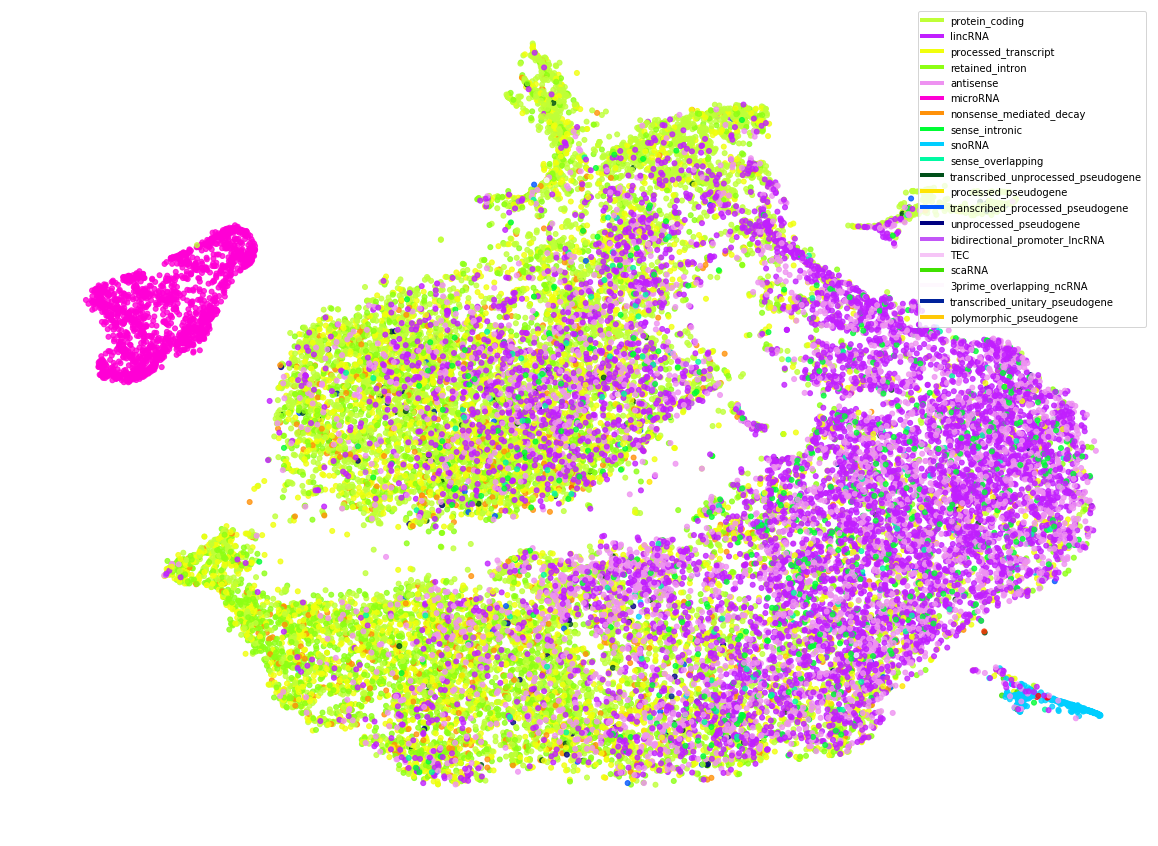

In [51]:
from moge.visualization.visualize_embedding import visualize_embedding
visualize_embedding(rna2rna_emb, network=network, node_label="locus_type", 
                    edgelist=network_test.get_edgelist(node_list=network_test.nodes, edge_types=["d"]),
#                     test_nodes=node_list,
                    cmap="gist_ncar",)

# Visualize Embeddings & Adjacency Matrix

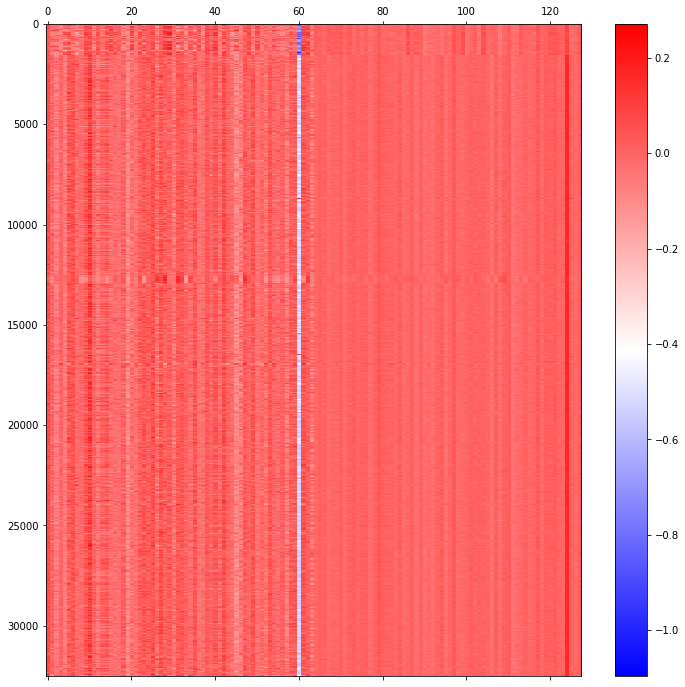

In [15]:
matrix_heatmap(siamese.get_embedding(), cmap="bwr", aspect='auto')

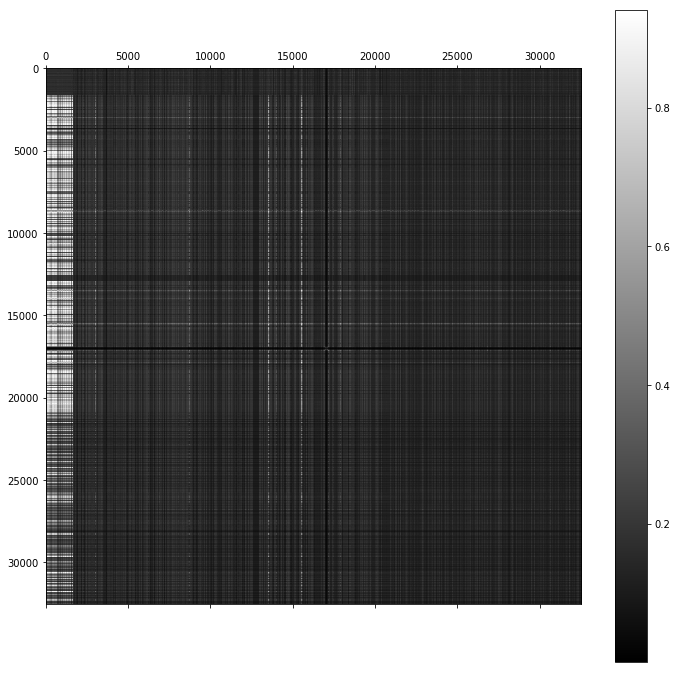

In [20]:
matrix_heatmap(rna2rna_emb.get_reconstructed_adj(edge_type="u", node_l=rna2rna_emb.node_list))

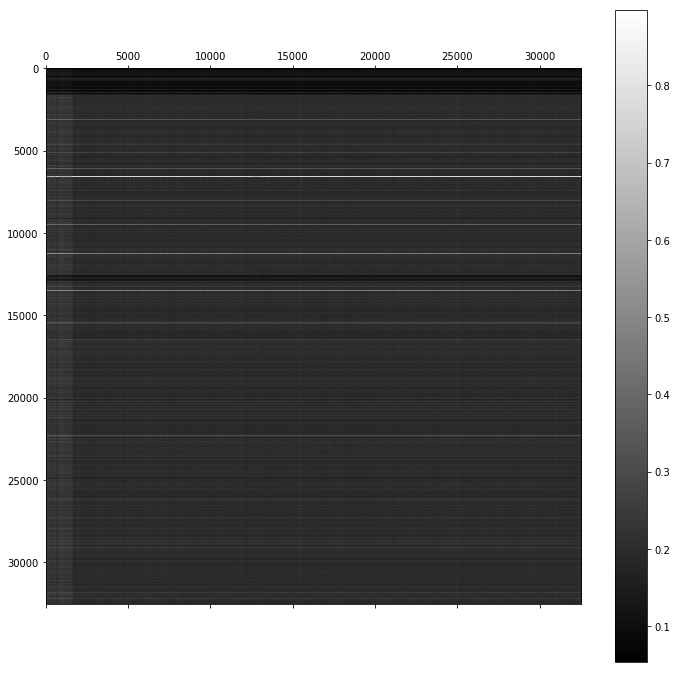

In [22]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", node_l=generator.node_list, beta=2.0))

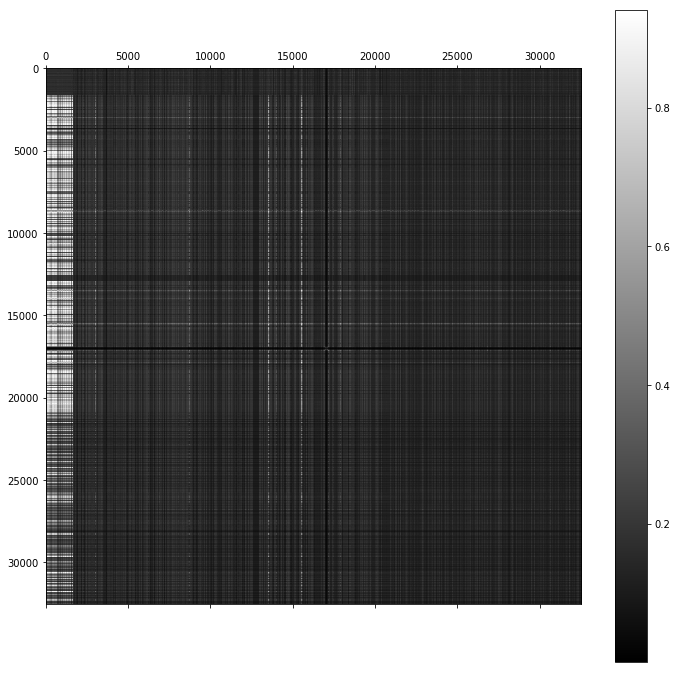

In [24]:
matrix_heatmap(rna2rna_emb.get_reconstructed_adj(edge_type="d", node_l=generator.node_list))

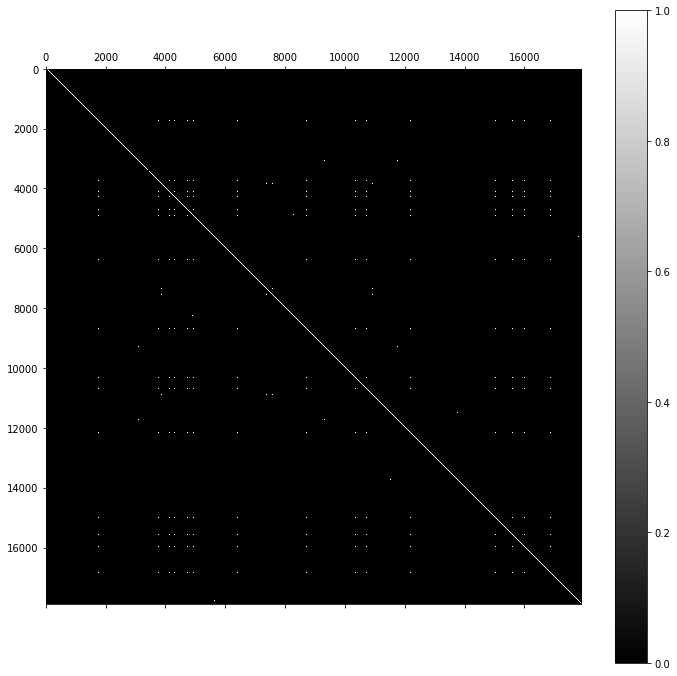

In [31]:
method = sdne_emb
matrix_heatmap(method.get_reconstructed_adj(node_l=method.node_list))

# Get top-k predicted edges for lung cancer associated lncRNAs

In [11]:
LNC = network.multi_omics_data.LNC.get_genes_info()

In [12]:
lung_lncRNAs = LNC[LNC["Disease association"].notnull() & LNC["Disease association"].str.contains("lung")].index.tolist()

In [13]:
lung_lncRNAs_nodes = list(set([v for u,v in network.G.edges(lung_lncRNAs)] + [u for u,v in network.G.edges(lung_lncRNAs)]))
lung_lncRNAs_nodes

['DCAF12',
 'DCLRE1A',
 'MIR4489',
 'PARD3-AS1',
 'BYSL',
 'LRRN1',
 'S100B',
 'MRGPRG',
 'THAP11',
 'SYN2',
 'NUP93',
 'RN7SKP266',
 'FERMT3',
 'HIST1H2BH',
 'VASH1',
 'DLX3',
 'GAPDHP25',
 'PDE6G',
 'PROZ',
 'COPS5',
 'RN7SL753P',
 'KRT1',
 'AMD1',
 'C15orf54',
 'hsa-mir-877',
 'AKR1C7P',
 'FKBP9P1',
 'HIST1H2AG',
 'RAB6C',
 'hsa-mir-4725',
 'KANSL1',
 'PSMC1P9',
 'VEGF',
 'PHF2',
 'CENPQ',
 'UNC93B3',
 'LOC728392',
 'PDK1',
 'MRFAP1',
 'LRRC23',
 'ZNF574',
 'hsa-mir-144',
 'CLIP2',
 'LINC01914',
 'hsa-mir-1234',
 'VTA1',
 'EP300',
 'CTPS1',
 'ZNF134',
 'BMP7-AS1',
 'ENSG00000272003',
 'FRRS1L',
 'RHAG',
 'SPOCD1',
 'UQCRC1',
 'SLTM',
 'AC011471.2',
 'NAPSB',
 'SALL2',
 'CYB5R3',
 'ATAD3A',
 'FAM47A',
 'RPL7P11',
 'ELL2',
 'HBP1',
 'TFAMP2',
 'FAM126A',
 'GPR180',
 'RNU6-832P',
 'IL6R',
 'SLC35G3',
 'LOC149373',
 'RPL35P1',
 'SHPK',
 'RNA5SP41',
 'EIF3F',
 'CHRNA5',
 'MLH3',
 'BGLT3',
 'JMJD4',
 'CD302',
 'OTUD7B',
 'SLC5A1',
 'SPHK1',
 'ZIK1',
 'AC062039.1',
 'HK3',
 'DGCR8',
 'KLK8

In [54]:
lung_lncRNAs_nodes = network.G.neighbors(lung_lncRNAs)

TypeError: unhashable type: 'list'

In [168]:
top_k_pred_edges = siamese.get_top_k_predicted_edges(edge_type="d", top_k=50, 
                                                     node_list=lung_lncRNAs_nodes,
                                                    remove_training_edges=True)

Embeddings filtered by node list (2015, 128)


In [169]:
top_k_pred_edges = [(u,v) for u,v,w in top_k_pred_edges if (u in siamese.node_list and v in siamese.node_list)]
len(top_k_pred_edges)

39

In [55]:
rna2rna_emb.predict_cluster()

array([3, 3, 3, ..., 7, 1, 5], dtype=int32)

# Gene Set Enrichment Analysis of Clusters

In [16]:
import gseapy as gp

In [18]:
names = gp.get_library_name()
names

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlex_2017',
 'CORUM',
 'Cancer_Cell_Line_Encyclopedia',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'Disease_Perturbations_from_GEO_down',
 'Disease_Perturbations_from_GEO_up',
 'Disease_Signatures_from_GEO_down_2014',
 'Disease_Signatures_from_GEO_up_2014',
 'DrugMatrix',
 'Drug_Perturbations_from_GEO_2014',
 'Drug_Perturbations_from_GEO_down',
 'Drug_Perturbations_from_GEO_up',
 'ENCODE_Histone_Modifications_2013',
 'ENCODE_Histone_Modifications_2015',
 'ENCODE_TF_ChIP-seq_2014',
 'ENCODE_TF_ChIP-seq_2015',
 'ENCODE_and_ChEA_Cons

In [52]:
enr = gp.enrichr(gene_list=lung_lncRNAs,
                 description='test_lung_nodes',
                 gene_sets=["KEGG_2018"],
#                  outdir='./enrichr_test_lung/',
                 no_plot=True,
                 cutoff=0.5 
                )
enr.results.sort_values(by="P-value").head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes
0,KEGG_2018,Glycosyltransferases sce01003,1/63,0.137961,0.275922,0.017501,0.035001,-1.464341,2.900544,GAS5
1,KEGG_2018,Chromosome and associated proteins sce03036,1/324,0.536304,0.536304,0.088871,0.088871,-1.818814,1.133220,GAS5


# Visualize Embeddings

In [181]:
from sklearn.metrics.pairwise import pairwise_distances
from moge.visualization.plot_data import matrix_heatmap
from scipy import sparse
# from sklearn.manifold import TSNE
from moge.visualization.visualize_embedding import get_node_color, plot_embedding2D
import matplotlib.pyplot as plt

In [182]:
from sklearn.decomposition import PCA

embs_pca = PCA(n_components=2).fit_transform(embs)

In [183]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(init=embs_pca, perplexity=80, n_jobs=8, verbose=True)
node_pos = tsne.fit_transform(embs)

In [36]:
g = network.G.subgraph(generator.node_list)
# g = nx.relabel.relabel_nodes(g, {k: v for v, k in enumerate(generator.node_list)})

In [189]:
generator.genes_info["locus_type"]

A1BG                                 protein_coding
A1CF                                 protein_coding
A2M                            processed_transcript
A2ML1                       nonsense_mediated_decay
A4GALT                         processed_transcript
A4GNT                                protein_coding
AAAS                                retained_intron
AACS                           processed_transcript
AACSP1           transcribed_unprocessed_pseudogene
AADAC                                protein_coding
AADACL2                              protein_coding
AADACL3                              protein_coding
AADACL4                              protein_coding
AADAT                                protein_coding
AAGAB                          processed_transcript
AAK1                           processed_transcript
AAMDC                       nonsense_mediated_decay
AAMP                                retained_intron
AANAT                                protein_coding
AAR2        

In [184]:
nodelist = generator.genes_info[generator.genes_info["Transcript sequence"].notnull()][
    generator.genes_info["locus_type"].isin([\
                                             "RNA, micro", 
                                             "lincRNA", 
                                             "sense_intronic"
                                             "protein_coding"
                                            ])].index.tolist()
nodelist = method.node_list
# nodelist = lung_lncRNAs
# nodelist = network_test.node_list
nodelist = [node for node in nodelist if node in method.node_list]
len(nodelist)

19532

In [191]:
edgelist = [(u,v) for u, v, d in network_test.G.edges(data=True) if (d["type"]=="d" and (u in nodelist and v in nodelist))]
np.random.shuffle(edgelist)
len(edgelist)

525651

In [187]:
node_labels = generator.genes_info.loc[nodelist]["locus_type"].astype(str) # "Transcript length", "locus_type", "Family"
sorted_node_labels = sorted(node_labels.unique(), reverse=True)
node_colormap = {f:sorted_node_labels.index(f)/len(sorted_node_labels) for f in node_labels.unique()}
node_colors = [node_colormap[n] if n in node_colormap.keys() else None for n in node_labels]      

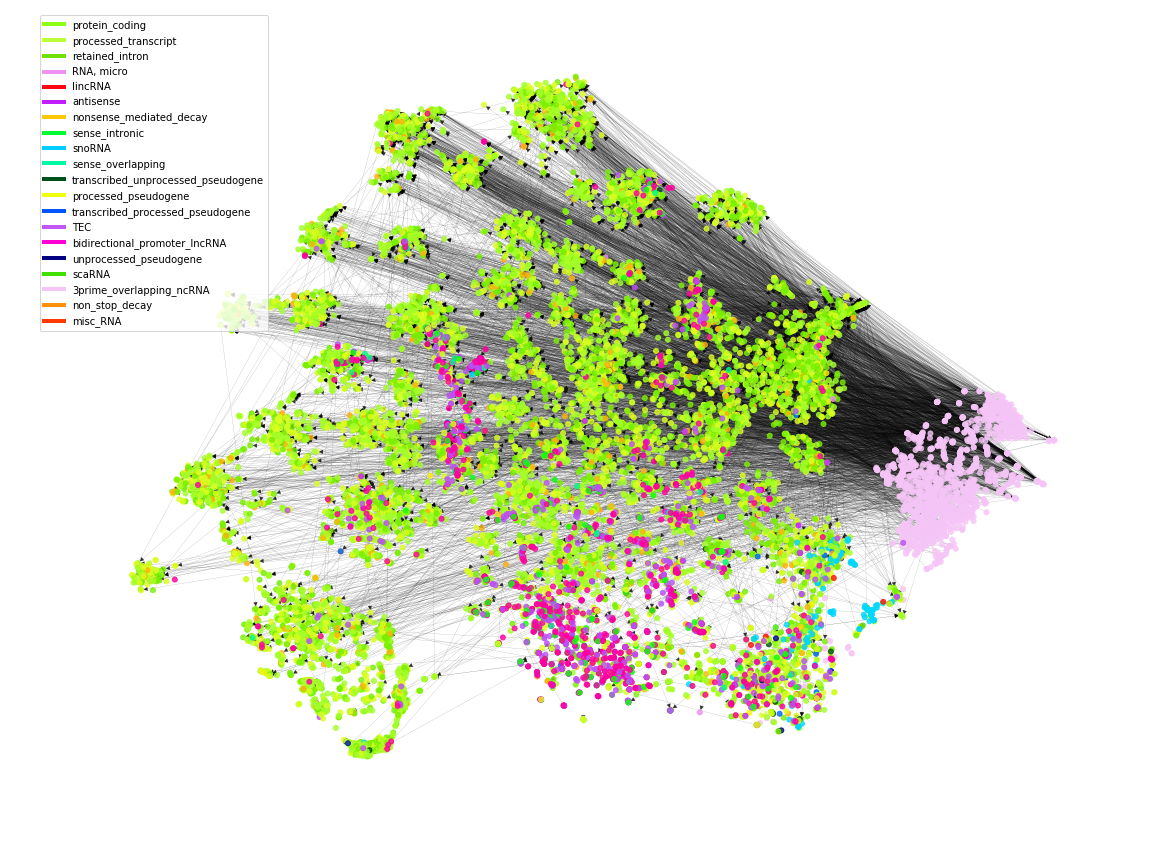

In [192]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

plot_embedding2D(method.get_node_pos(), node_list=method.node_list, node_colors=node_colors,
                 legend=True, node_labels=node_labels, node_colormap=node_colormap, legend_size=20,
                 di_graph=g, cmap="gist_ncar", nodelist=nodelist,
                 plot_nodes_only=False, edgelist=edgelist[0:5000], 
                 with_labels=False, figsize=(20,15),
#                  file_name="moge/data/LMN_only_directed/results/LMN_sne_viz_edges.pdf"
                )


In [59]:
plt.savefig("moge/data/LMN_only_directed/results/LMN_sne_viz_edges.pdf")

<Figure size 432x288 with 0 Axes>